In [93]:
from openff.toolkit import ForceField, Molecule
from openmm import openmm
from openmm import unit
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Draw
import numpy as np

In [94]:
class Reporter(openmm.MinimizationReporter):
    interval = 10 # report interval
    energies = [] # array to record progress
    def report(self, iteration, x, grad, args):
        # print current system energy to screen 
        if iteration % self.interval == 0:
            print(iteration, args['system energy'])

        # save energy at each iteration to an array we can use later
        self.energies.append(args['system energy'])

        # The report method must return a bool specifying if minimization should be stopped. 
        return False

In [95]:
mol = Molecule.from_smiles('CCCC(O)CC(N)CCC', allow_undefined_stereo=True)
mol.generate_conformers()
# mol.assign_partial_charges(partial_charge_method='am1bccelf10')

In [96]:
print(f"Number of atoms in molecule: {mol.n_atoms}")
print(f"Number of conformers: {len(mol.conformers)}")


Number of atoms in molecule: 32
Number of conformers: 1


In [97]:
forcefield = ForceField('harmonic-force-field.offxml', load_plugins = True, allow_cosmetic_attributes = True)
# forcefield = ForceField('openff-2.2.0.offxml')

In [98]:
system = forcefield.create_openmm_system(mol.to_topology())

In [99]:
for i in range(system.getNumForces()):
    force = system.getForce(i)
    print(f"Force {i}: {type(force)}")


Force 0: <class 'openmm.openmm.NonbondedForce'>
Force 1: <class 'openmm.openmm.PeriodicTorsionForce'>
Force 2: <class 'openmm.openmm.HarmonicAngleForce'>
Force 3: <class 'openmm.openmm.HarmonicBondForce'>
Force 4: <class 'openmm.openmm.CustomCompoundBondForce'>


In [100]:
print(system.getNumParticles()) 

32


In [101]:
integrator = openmm.LangevinIntegrator(
    300.0 * unit.kelvin, 1.0 / unit.picosecond, 2.0 * unit.femtosecond
)
platform = openmm.Platform.getPlatformByName("Reference")
context = openmm.Context(system, integrator, platform)

initial_positions = mol.conformers[0].to_openmm()
context.setPositions(initial_positions)

# Create an instance of our reporter
reporter = Reporter()

# Perform local energy minimization
print("Minimizing energy...")
openmm.LocalEnergyMinimizer.minimize(
    context, tolerance=1e-2, maxIterations=1500, reporter=reporter
)

Minimizing energy...
0 78.79150316939224
10 11.717276388105994
20 -9.602127315456332
30 -16.743742205913822
40 -19.866019923211837
50 -21.09889320359357
60 -21.919793728676773
70 -22.294663210538513
80 -22.439093987931766
90 -22.48495064006383
100 -22.527762508228207
110 -22.54660746590117
120 -22.5576601992208
130 -22.56589016151189
140 -22.572805840813867
150 -22.578274713905124
160 -22.58092039988105
170 -22.581437657363995
180 -22.581944730330687
190 -22.582439165468127
200 -22.582647633780226
210 -22.582793815443072
220 -22.582910741032265
230 -22.583004780801726
240 -22.583100830551906
250 -22.583140004155243
260 -22.58316214755201
270 -22.58317420323098
280 -22.583176817489587
290 -22.58317834548702
300 -22.583178979229096
310 -22.583179388467368
320 -22.583179665720493
330 -22.58317994655671
340 -22.58318010343469
350 -22.583180242657807
360 -22.583180280550447
370 -22.583180326533363
380 -22.583180359026812


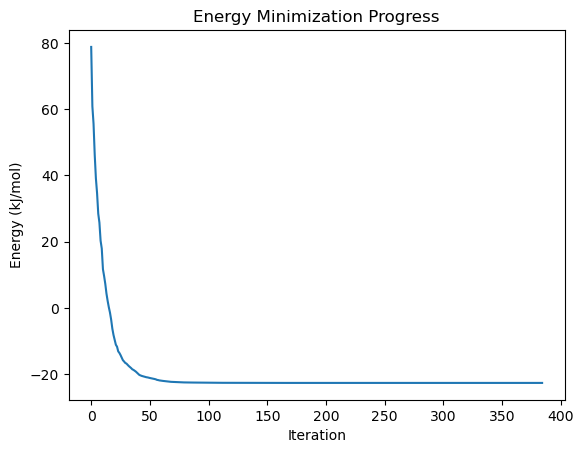

In [102]:
plt.plot(reporter.energies)
plt.xlabel("Iteration")
plt.ylabel("Energy (kJ/mol)")
plt.title("Energy Minimization Progress")
plt.show()

In [82]:
xml_file_name = "harmonic_benchmark_system.xml"
with open(xml_file_name, "w") as xml_file:
    xml_file.write(openmm.XmlSerializer.serialize(system))